In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
def get_direct_link(shared_link):
    return 'https://drive.google.com/uc?export=download&id=' + shared_link.split('/')[-2]

link = "https://drive.google.com/file/d/1I4eXgl3gDDobOfIEz1i7rmHXaB5pxMEy/view?usp=drive_link"
direct_link = get_direct_link(link)
df = pd.read_csv(direct_link)

In [3]:
df.loc[(df.player=='Hercog P.')&(df.Date == '2019-03-23')]

,match_id,player,Date,Year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome
16425,14598,Hercog P.,2019-03-23,2019,-0.001824,0.032569,0.181818,0.540541,0.47619,1


In [4]:
hercog_idx = df.loc[(df.player=='Hercog P.')&(df.Date == '2019-03-23')].index[0]

In [5]:
df.drop(index=hercog_idx, inplace=True)

In [6]:
df = df.sort_values(by='Date')

split_index = int(0.75 * len(df))

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

test_df.reset_index(drop=True, inplace=True)

print('Fit set rows: '+str(len(train_df)))
print('Test set rows: '+str(len(test_df)))

Fit set rows: 25530
Test set rows: 8511


In [7]:
train_df.Date = pd.to_datetime(train_df.Date, format='%Y-%m-%d')
train_df = train_df.sort_values(by='Date')

test_df.Date = pd.to_datetime(test_df.Date, format='%Y-%m-%d')
test_df = test_df.sort_values(by='Date')

In [8]:
print(train_df.Date.min(),train_df.Date.max(),test_df.Date.min(),test_df.Date.max())

2015-07-02 00:00:00 2021-09-01 00:00:00 2021-09-01 00:00:00 2023-07-30 00:00:00


In [9]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(rank=True, wiki=True):
    features = ['inverse_avg']
    if rank:
        features.append('rankdist')
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds, rankdist=None, wikibuzz=None):
    prob = coef[0] + coef[1] * inv_odds  
    if rankdist is not None:
        prob += coef[2] * rankdist
    if wikibuzz is not None:
        prob += coef[-1] * wikibuzz
    return prob

def kelly(implied_prob, predicted_prob):
    return max(predicted_prob - ((1 - predicted_prob) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake * (1 / implied_prob - 1) if outcome == 1 else -stake

def estimate_probabilities(test_data, coef, odds_provider, use_rank=True, use_wiki=True):
    if use_rank and use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], row['rankdist'], row['wikibuzz']), axis=1)
    elif use_rank:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], rankdist=row['rankdist']), axis=1)
    elif use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], wikibuzz=row['wikibuzz']), axis=1)
    else:
        test_data['est_prob'] = test_data['inverse_avg'].apply(lambda x: model_prob(coef, x))

    return test_data

def display_results(test_data, odds_provider):
    bet_considered = len(test_data[test_data[f'inverse_{odds_provider}'].notna()])
    bets_placed = len(test_data.loc[(test_data["correct_profit"].notna()) & (test_data["correct_profit"] != 0)])
    mean_overround = ((test_data.sort_values(by="match_id")[f"inverse_{odds_provider}"].rolling(2).sum().iloc[1::2].mean() - 1) * 100)
    total_stake = test_data['correct_stake'].sum()
    total_return = test_data['correct_profit'].sum()
    roi = (((total_return + total_stake) / total_stake) - 1) * 100
    
    results = {
        'Bets considered (2 * Matches)': bet_considered,
        'Number of bets placed': bets_placed,
        'Mean overround (%)': mean_overround,
        'Absolute amount bet': total_stake,
        'Absolute return': total_return,
        'ROI (%)': roi
    }
    
    return results

def show_results(test_data, coef, odds_provider, rank=True, wiki=True):
    test_data = estimate_probabilities(test_data, coef, odds_provider, rank, wiki)
    
    test_df['original_stake'] = [kelly(a,b) for a,b in zip(test_df['inverse_{}'.format(odds_provider)], test_df['est_prob'])]
    test_df['original_profit'] = [profit(a,b,c) for a,b,c in zip(test_df['original_stake'],test_df['inverse_{}'.format(odds_provider)],test_df['outcome'])]
    test_df['post-bet_balance'] = (test_df['original_profit'] + 1).cumprod()
    test_df['pre-bet_balance'] = test_df['post-bet_balance'].shift(1)
    test_df['correct_stake'] = test_df['original_stake'] * test_df['pre-bet_balance']
    test_df['correct_profit'] = test_df['original_profit'] * test_df['pre-bet_balance']
    
    results = display_results(test_data, odds_provider)
    print(results)
    return results

def plot_results(test_df):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('Date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)

    ax.set_title('Cumulative Profit Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)

    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()

def plot_results_save(test_df, filename, title):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('Date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


{'Bets considered (2 * Matches)': 8511, 'Number of bets placed': 2409, 'Mean overround (%)': 5.3438893083703976, 'Absolute amount bet': 177.91629496028727, 'Absolute return': -0.9999999999998883, 'ROI (%)': -0.5620620641988427}


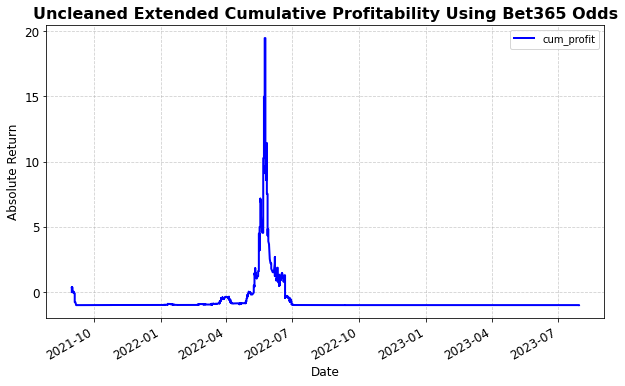

In [10]:
# preferred model on B365
coef = train_model()
show_results(test_df, coef, 'B365')
plot_results_save(test_df, 'unclean_tennis_1.png', "Uncleaned Extended Cumulative Profitability Using Bet365 Odds")

In [11]:
test_df.sort_values(by='correct_profit', ascending=True)

,match_id,player,Date,Year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
2882,5751,Osorio M.,2022-05-25,2022,-0.004842,-5.331683,0.694444,0.684932,0.653595,0,0.811202,0.382115,-0.382115,11.566668,18.719775,7.153107,-7.153107,10.566668
2913,12728,Saville D.,2022-05-27,2022,0.009075,-3.417712,0.421941,0.440529,0.406504,0,0.513346,0.158125,-0.158125,9.587270,11.387991,1.800721,-1.800721,8.587270
3298,8955,Badosa P.,2022-06-21,2022,-0.244083,-5.303196,0.819672,0.826446,0.800000,0,0.947166,0.707010,-0.707010,0.612112,2.089192,1.477080,-1.477080,-0.387888
2936,18398,Cornet A.,2022-05-28,2022,-0.011486,-3.961405,0.434783,0.450450,0.429185,0,0.538741,0.183927,-0.183927,5.955484,7.297732,1.342248,-1.342248,4.955484
3006,18162,Frech M.,2022-06-07,2022,-0.006596,-3.954672,0.781250,0.775194,0.751880,0,0.860470,0.362149,-0.362149,2.347560,3.680422,1.332862,-1.332862,1.347560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,9612,Muchova K.,2022-05-22,2022,-0.008393,-4.127240,0.909091,0.909091,0.884956,1,0.998184,0.980022,0.098002,10.915462,9.941202,9.742594,0.974259,9.915462
2760,15875,Stephens S.,2022-05-22,2022,-0.005821,-3.327633,0.333333,0.370370,0.333333,1,0.440969,0.161454,0.322907,7.327146,5.538669,0.894238,1.788477,6.327146
2827,4328,Garcia C.,2022-05-24,2022,-0.009734,-1.253212,0.400000,0.432900,0.400000,1,0.442378,0.070630,0.105945,20.465133,18.504652,1.306988,1.960481,19.465133
2793,217,Tomljanovic A.,2022-05-23,2022,0.176190,-2.409275,0.285714,0.298507,0.250000,1,0.345591,0.083828,0.209569,15.444404,12.768516,1.070355,2.675888,14.444404


{'Bets considered (2 * Matches)': 8511, 'Number of bets placed': 2400, 'Mean overround (%)': 5.3438893083703976, 'Absolute amount bet': 280.4901969925361, 'Absolute return': -0.9999999999999366, 'ROI (%)': -0.3565186985934332}


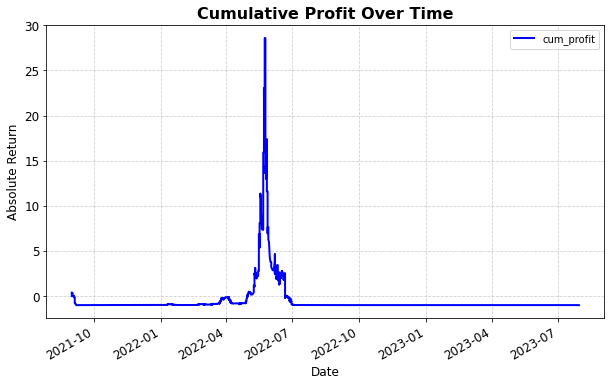

In [12]:
# PM w/o rank on B365
coef = train_model(rank=False)
show_results(test_df, coef, 'B365', rank = False)
plot_results(test_df)

{'Bets considered (2 * Matches)': 8511, 'Number of bets placed': 4247, 'Mean overround (%)': -0.14357584424750103, 'Absolute amount bet': 515511.60981302866, 'Absolute return': -0.9999999999899007, 'ROI (%)': -0.0001939820521879021}


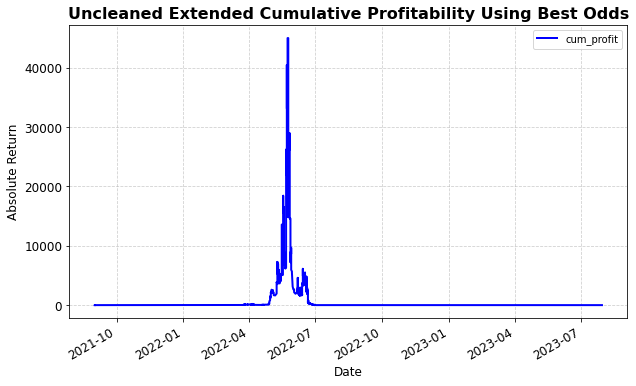

In [13]:
# preferred model on best
coef = train_model()
show_results(test_df, coef, 'best')
plot_results_save(test_df, 'unclean_tennis_2.png', "Uncleaned Extended Cumulative Profitability Using Best Odds")